# **Real-Time Violence Detection in Surveillance Videos**

In [ ]:
!pip install pydub
!pip install tensorflow-datasets

In [ ]:
import tensorflow_datasets as tfds
ds_splits, ds_info = tfds.load(
    "crema_d",
    split=["train", "test"],
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

In [ ]:

for audio, label in ds_splits[0].take(1):
    print("Audio shape:", audio.shape)
    print("Label (int):", label.numpy())

In [ ]:
#!git clone https://github.com/CheyneyComputerScience/CREMA-D.git
import os
from IPython.display import Audio, Video, display

audio_dir = os.path.expanduser("/content/CREMA-D/AudioWAV")
video_dir = os.path.expanduser("/content/CREMA-D/VideoFlash")
audio_file = "1001_DFA_ANG_XX.wav"  # Replace with an actual audio file name
video_file = "1001_DFA_ANG_XX.flv"  # Replace with an actual video file name
audio_path = os.path.join(audio_dir, audio_file)
video_path = os.path.join(video_dir, video_file)

print("▶ Playing audio:", audio_file)
display(Audio(audio_path, autoplay=False))

print("▶ Showing video:", video_file)
display(Video(video_path, embed=True, width=400))

print("Audio sample rate & shape can be inferred automatically by IPython.display.")
print("Video resolution & length will appear in the player’s controls.")

In [ ]:
!apt-get update && apt-get install -y ffmpeg

In [ ]:
import os
import subprocess

video_dir = os.path.expanduser("/content/CREMA-D/VideoFlash")
output_dir = os.path.expanduser("/content/CREMA-D/VideoMP4")
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(video_dir):
    if filename.endswith(".flv"):
        input_path = os.path.join(video_dir, filename)
        output_path = os.path.join(output_dir, filename[:-4] + ".mp4")
        subprocess.run(["ffmpeg", "-i", input_path, output_path])
        print(f"Converted {filename} to {filename[:-4] + '.mp4'}")

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('AudioWAV', 'zip', '/content/CREMA-D/AudioWAV')

files.download('AudioWAV.zip')

In [ ]:
!pip install librosa opencv-python-headless

In [ ]:
import os
import numpy as np
import librosa
import cv2
from glob import glob

AUDIO_DIR = "/content/CREMA-D/AudioWAV"
VIDEO_DIR = "/content/CREMA-D/VideoFlash"

In [ ]:
def preprocess_audio(file_path, sr=16000, duration=3.0, n_mels=64):
    y, orig_sr = librosa.load(file_path, sr=None)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    max_len = int(sr * duration)
    y = np.pad(y, (0, max_len - len(y)), mode='constant') if len(y) < max_len else y[:max_len]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel_norm = (log_mel - log_mel.min()) / (log_mel.max() - log_mel.min())
    log_mel_norm = log_mel_norm[..., np.newaxis]
    return log_mel_norm.astype(np.float32)

In [ ]:
def preprocess_video(file_path, num_frames=16, frame_size=(224, 224)):
    cap = cv2.VideoCapture(file_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total-1, num_frames).astype(int)
    frames = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame.astype(np.float32))
    cap.release()
    if len(frames) < num_frames:
        pad = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.float32)
        frames += [pad] * (num_frames - len(frames))
    return np.stack(frames)

In [ ]:
audio_files = glob(os.path.join(AUDIO_DIR, "*.wav"))
video_files = glob(os.path.join(VIDEO_DIR, "*.flv"))

if audio_files and video_files:
    spec = preprocess_audio(audio_files[0])
    vid  = preprocess_video(video_files[0])
    print("Log-Mel Spectrogram shape:", spec.shape)
    print("Video frames shape:", vid.shape)
else:
    print("❗ Update AUDIO_DIR and VIDEO_DIR to point to your CREMA-D folders")

In [ ]:
EMOTION_LABELS = {
    "ANG": "Angry",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad",
    "SUR": "Surprise"
}


In [ ]:
from collections import Counter
import os

all_audio_files = glob("/content/CREMA-D/AudioWAV/*.wav")
all_video_files = glob("/content/CREMA-D/VideoFlash/*.flv")

labels = [f.split("_")[2] for f in all_audio_files]
label_counts = Counter(labels)

print("Number of audio samples:", len(all_audio_files))
print("Number of video samples:", len(all_video_files))
print("Emotion distribution:", label_counts)


In [ ]:
import matplotlib.pyplot as plt

plt.bar(label_counts.keys(), label_counts.values())
plt.title("Emotion Label Distribution (CREMA-D)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [ ]:
from glob import glob
import os

AUDIO_DIR = "/content/CREMA-D/AudioWAV"
all_audio_files = glob(os.path.join(AUDIO_DIR, "*.wav"))

def get_sample_path(emotion_code):
    for f in all_audio_files:
        if f"_{emotion_code}_" in os.path.basename(f):
            return f
    return None

path_angry = get_sample_path("ANG")
path_happy = get_sample_path("HAP")


In [ ]:
plt.imshow(spec, aspect='auto', cmap='magma')
plt.title("Log-Mel Spectrogram Example")
plt.xlabel("Time")
plt.ylabel("Mel Band")
plt.colorbar()
plt.show()

In [ ]:
plt.hist(spec.flatten(), bins=50, color='skyblue')
plt.title("Log-Mel Spectrogram Value Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

print(f"Spec stats → min: {spec.min():.2f}, max: {spec.max():.2f}, mean: {spec.mean():.2f}")


In [ ]:
spec_angry = preprocess_audio(path_angry)
spec_happy = preprocess_audio(path_happy)

plt.subplot(1, 2, 1)
plt.imshow(spec_angry, aspect='auto', cmap='magma')
plt.title("Angry")

plt.subplot(1, 2, 2)
plt.imshow(spec_happy, aspect='auto', cmap='magma')
plt.title("Happy")
plt.show()


In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(vid[i])
    ax.set_title(f"Frame {i}")
    ax.axis('off')
plt.suptitle("Sample Video Frames")
plt.tight_layout()
plt.show()


In [ ]:
plt.hist(vid.flatten(), bins=50)
plt.title("Distribution of Pixel Values (Video Frames)")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()

print(f"Video mean: {vid.mean():.2f}, std: {vid.std():.2f}")


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

def extract_audio_features(path):
    spec = preprocess_audio(path)
    features = spec.flatten()
    features = np.nan_to_num(features, nan=0.0)
    return features

X = []
y = []
for path in all_audio_files:
    label = path.split("_")[2]
    X.append(extract_audio_features(path))
    y.append(label)

X = np.array(X)

X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='tab10')
plt.title("PCA of Audio Features by Emotion")
plt.show()

In [ ]:
def get_rms_energy(path):
    y, sr = librosa.load(path)
    return librosa.feature.rms(y=y).mean()

import pandas as pd

emotion_stats = []
for path in all_audio_files:
    emotion = path.split("_")[2]
    rms = get_rms_energy(path)
    emotion_stats.append((emotion, rms))

df = pd.DataFrame(emotion_stats, columns=["emotion", "rms"])
sns.boxplot(data=df, x="emotion", y="rms")
plt.title("RMS Energy by Emotion")
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = MobileNetV2(include_top=False, pooling='avg', input_shape=(224, 224, 3))

def get_frame_embedding(frame):
    x = preprocess_input(np.expand_dims(frame, 0))
    return model.predict(x)[0]

video_embeddings = []
labels = []
for path in video_files[:100]:
    emotion = path.split("_")[2]
    frames = preprocess_video(path)
    emb = get_frame_embedding(frames[8])
    video_embeddings.append(emb)
    labels.append(emotion)

X_pca = PCA(n_components=2).fit_transform(video_embeddings)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels)
plt.title("PCA of Video Frame Embeddings")
plt.show()


In [ ]:
import os
import random
from glob import glob
import numpy as np
import cv2
import librosa
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define directories
AUDIO_DIR = os.path.expanduser("/content/CREMA-D/AudioWAV")
VIDEO_DIR = os.path.expanduser("/content/CREMA-D/VideoFlash")
PROCESSED_DATA_DIR = "/content/processed_data"
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

def preprocess_audio(audio_file, sr=22050, n_mels=128, hop_length=512, n_fft=2048, duration=3, target_shape=(128,128)):
    y, sr = librosa.load(audio_file, sr=sr, duration=duration)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())
    mel_spect_resized = resize(mel_spect_db, target_shape, anti_aliasing=True)
    return mel_spect_resized[..., np.newaxis]

def preprocess_video(video_file, num_frames=16, frame_size=(224,224)):
    cap = cv2.VideoCapture(video_file)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        return np.zeros((num_frames, *frame_size, 3))
    step = max(total_frames // num_frames, 1)
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros_like(frames[0]) if frames else np.zeros((*frame_size, 3)))
    return np.array(frames[:num_frames])

def prepare_data(audio_files, video_files, labels, test_size=0.2, val_size=0.1):
    audio_features = [preprocess_audio(audio_file) for audio_file in audio_files]
    audio_features = np.array(audio_features)

    video_features = [preprocess_video(video_file) for video_file in video_files]
    video_features = np.array(video_features)

    labels = np.array(labels)

    X_audio_temp, X_audio_test, X_video_temp, X_video_test, y_temp, y_test = train_test_split(
        audio_features, video_features, labels, test_size=test_size, random_state=42, stratify=labels
    )

    val_size_adjusted = val_size / (1 - test_size)
    X_audio_train, X_audio_val, X_video_train, X_video_val, y_train, y_val = train_test_split(
        X_audio_temp, X_video_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
    )

    np.save(os.path.join(PROCESSED_DATA_DIR, "X_audio_train.npy"), X_audio_train)
    np.save(os.path.join(PROCESSED_DATA_DIR, "X_video_train.npy"), X_video_train)
    np.save(os.path.join(PROCESSED_DATA_DIR, "y_train.npy"), y_train)
    np.save(os.path.join(PROCESSED_DATA_DIR, "X_audio_val.npy"), X_audio_val)
    np.save(os.path.join(PROCESSED_DATA_DIR, "X_video_val.npy"), X_video_val)
    np.save(os.path.join(PROCESSED_DATA_DIR, "y_val.npy"), y_val)
    np.save(os.path.join(PROCESSED_DATA_DIR, "X_audio_test.npy"), X_audio_test)
    np.save(os.path.join(PROCESSED_DATA_DIR, "X_video_test.npy"), X_video_test)
    np.save(os.path.join(PROCESSED_DATA_DIR, "y_test.npy"), y_test)

    return (X_audio_train, X_video_train, y_train,
            X_audio_val, X_video_val, y_val,
            X_audio_test, X_video_test, y_test)

def build_audio_model(input_shape):
    input_audio = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_audio)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    model = Model(inputs=input_audio, outputs=x, name='audio_model')
    return model

def build_video_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape[1:])
    base_model.trainable = False
    input_video = Input(shape=input_shape)
    x = TimeDistributed(base_model)(input_video)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    model = Model(inputs=input_video, outputs=x, name='video_model')
    return model

def build_multimodal_model(audio_shape, video_shape):
    audio_model = build_audio_model(audio_shape)
    video_model = build_video_model(video_shape)
    input_audio = Input(shape=audio_shape)
    input_video = Input(shape=video_shape)
    audio_features = audio_model(input_audio)
    video_features = video_model(input_video)
    combined = Concatenate()([audio_features, video_features])
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_audio, input_video], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_model(model, X_audio_train, X_video_train, y_train, X_audio_val, X_video_val, y_val, epochs=50, batch_size=16):
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    history = model.fit(
        [X_audio_train, X_video_train],
        y_train,
        validation_data=([X_audio_val, X_video_val], y_val),
        epochs=epochs,
        class_weight=class_weight_dict,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )
    return history

def evaluate_model(model, X_audio_test, X_video_test, y_test):
    results = model.evaluate([X_audio_test, X_video_test], y_test, verbose=1)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")
    y_pred = model.predict([X_audio_test, X_video_test])
    y_pred_binary = (y_pred > 0.5).astype(int)
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_binary))
    return results

def visualize_performance(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    all_audio_files = glob(os.path.join(AUDIO_DIR, "*.wav"))
    random.shuffle(all_audio_files)

    violent_samples = []
    non_violent_samples = []
    max_samples_per_class = 250

    for audio_file in all_audio_files:
        base_name = os.path.basename(audio_file)[:-4]
        video_file = os.path.join(VIDEO_DIR, f"{base_name}.flv")

        if os.path.exists(video_file):
            if "_ANG_" in base_name or "_FEA_" in base_name:
                if len(violent_samples) < max_samples_per_class:
                    violent_samples.append((audio_file, video_file, 1))
            else:
                if len(non_violent_samples) < max_samples_per_class:
                    non_violent_samples.append((audio_file, video_file, 0))

            if len(violent_samples) >= max_samples_per_class and len(non_violent_samples) >= max_samples_per_class:
                break

    balanced_samples = violent_samples + non_violent_samples
    random.shuffle(balanced_samples)

    audio_files = [sample[0] for sample in balanced_samples]
    video_files = [sample[1] for sample in balanced_samples]
    labels = [sample[2] for sample in balanced_samples]

    print(f"Collected {len(violent_samples)} Violent samples")
    print(f"Collected {len(non_violent_samples)} Non-Violent samples")
    print(f"Total samples: {len(balanced_samples)}")

    X_audio_train, X_video_train, y_train, X_audio_val, X_video_val, y_val, X_audio_test, X_video_test, y_test = prepare_data(
        audio_files, video_files, labels
    )

    audio_shape = X_audio_train[0].shape
    video_shape = X_video_train[0].shape
    print(f"Audio shape: {audio_shape}")
    print(f"Video shape: {video_shape}")

    model = build_multimodal_model(audio_shape, video_shape)
    model.summary()

    history = train_model(
        model,
        X_audio_train, X_video_train, y_train,
        X_audio_val, X_video_val, y_val,
        epochs=50,
        batch_size=16
    )

    evaluate_model(model, X_audio_test, X_video_test, y_test)
    visualize_performance(history)
    model.save('violence_detection_model.h5')
    print("Model saved successfully.")

if __name__ == "__main__":
    main()

Total samples: 100
Violent samples: 30
Non-violent samples: 70
Audio shape: (64, 94, 1)
Video shape: (16, 224, 224, 3)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 94, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 16, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_model         │ (None, 128)       │  2,175,360 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_model         │ (None, 128)       │ 24,376,736 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ audio_model[0][0… │
│ (Concatenate)       │                   │            │ video_model[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,650,913 (101.67 MB)

 Trainable params: 4,848,129 (18.49 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4549 - loss: 0.6980
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 198s 27s/step - accuracy: 0.4519 - loss: 0.7018 - val_accuracy: 0.7000 - val_loss: 0.6714
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.5659 - loss: 0.7158
Epoch 2: val_accuracy did not improve from 0.70000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5637 - loss: 0.7207 - val_accuracy: 0.7000 - val_loss: 0.6560
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.4753 - loss: 0.7952
Epoch 3: val_accuracy did not improve from 0.70000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4708 - loss: 0.7924 - val_accuracy: 0.7000 - val_loss: 0.6751
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.4379 - loss: 0.7635
Epoch 4: val_accuracy did not improve from 0.70000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4499 - loss: 0.7546 - val_accuracy: 0.7000 - val_loss: 0.6726
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.5698 - loss: 0.7086
Epoch 5: val_accuracy did not improve from 0.70000
3/3 ━━━━━

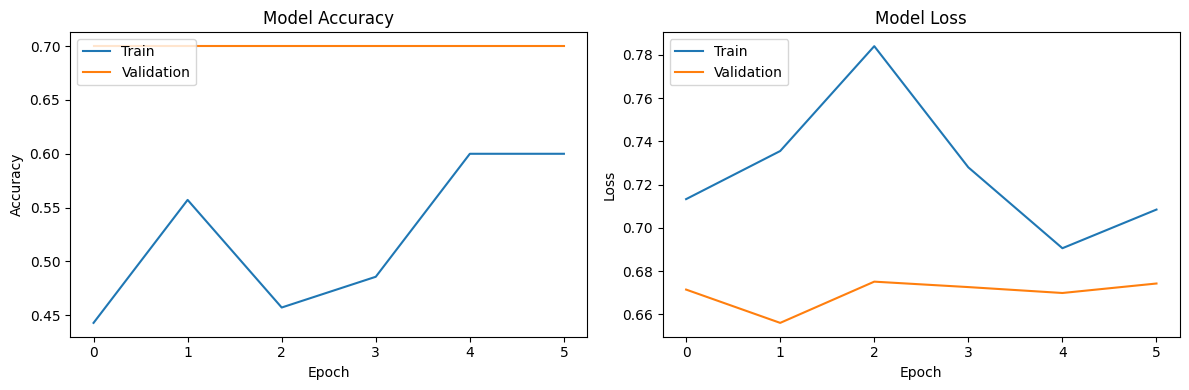

Model saved successfully.


In [ ]:
# main()

In [ ]:
!pip install lime
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=48f66b3a51868dda8d97ada872c46e9999c8a5f44ed9e1f546da2a5971d6bd89
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
from IPython.display import display, Image, HTML

In [ ]:
model = load_model('violence_detection_model.h5')

X_audio_test = np.load(os.path.join(PROCESSED_DATA_DIR, "X_audio_test.npy"))
X_video_test = np.load(os.path.join(PROCESSED_DATA_DIR, "X_video_test.npy"))
y_test = np.load(os.path.join(PROCESSED_DATA_DIR, "y_test.npy"))

In [ ]:
def get_intermediate_models(model):
    audio_input = model.input[0]
    audio_model = model.get_layer('audio_model')
    audio_output = audio_model(audio_input)

    video_input = model.input[1]
    video_model = model.get_layer('video_model')
    video_output = video_model(video_input)

    audio_feature_model = tf.keras.Model(inputs=audio_input, outputs=audio_output)
    video_feature_model = tf.keras.Model(inputs=video_input, outputs=video_output)

    return audio_feature_model, video_feature_model

audio_feature_model, video_feature_model = get_intermediate_models(model)

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image('model_architecture.png'))

In [ ]:
y_pred = model.predict([X_audio_test, X_video_test])
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Non-Violent', 'Violent'])
plt.yticks([0.5, 1.5], ['Non-Violent', 'Violent'])
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Non-Violent', 'Violent']))


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred[y_test == 0], bins=20, alpha=0.5, label='Non-Violent', color='green')
plt.hist(y_pred[y_test == 1], bins=20, alpha=0.5, label='Violent', color='red')
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability of Violence')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def show_sample_predictions(X_audio, X_video, y_true, y_pred, indices):
    for i in indices:
        print(f"Sample {i}:")
        print(f"True label: {'Violent' if y_true[i] == 1 else 'Non-Violent'}")
        print(f"Predicted probability: {y_pred[i][0]:.4f}")
        print(f"Predicted label: {'Violent' if y_pred[i][0] > 0.5 else 'Non-Violent'}")
        print(f"Correct prediction: {(y_true[i] == (y_pred[i][0] > 0.5))}")
        print("-----------------------------------")

correct_indices = np.where((y_test == (y_pred > 0.5).astype(int).reshape(-1)))[0]
confident_correct = correct_indices[np.argsort(np.abs(y_pred[correct_indices, 0] - 0.5))[-5:]]

incorrect_indices = np.where((y_test != (y_pred > 0.5).astype(int).reshape(-1)))[0]
confident_incorrect = incorrect_indices[np.argsort(np.abs(y_pred[incorrect_indices, 0] - 0.5))[-5:]]

print("Most confidently correct predictions:")
show_sample_predictions(X_audio_test, X_video_test, y_test, y_pred, confident_correct)

print("\nMost confidently incorrect predictions:")
show_sample_predictions(X_audio_test, X_video_test, y_test, y_pred, confident_incorrect)

In [ ]:
!pip install lime
!pip install scikit-image

In [ ]:
!pip install lime scikit-image librosa matplotlib pandas tensorflow opencv-python

# **Model paper 3**